# Sunrise Housing Case study

## Objective

Identify prospective properties to invest in based on the prediction of the actual value of these properties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import relativedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# load the dataset
inp0 = pd.read_csv('train.csv', header=0)
inp0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### I.  Data understanding

Following features are total values found in the dataset:<br>
TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF ; drop columns<br>
TotRmsAbvGrd = BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr<br>
GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF<br>
However, cannot drop the individual features that sum up to the totals until the correlation matrix is known under EDA

**1. Number of rows, columns and column names**

In [3]:
inp0.shape

(1460, 81)

In [4]:
print(list(inp0.columns))

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

**Observation**<br>
1. Number of rows = 1460. Number of columns = 81.<br>
2. Large number of columns implies that many will need to be dropped or they can be used to derive new metrics.

**2. Drop feature Id**<br>
Id is used for identification and is not known when the unseen data is processed.

In [5]:
col_drop = ['Id']

**3. Presence of NaN or Null**

In [6]:
#presence of NaN values & Null values
print('NaN : ' , list( [inp0[i].isna().sum() for i in inp0.columns]))
print('Null: ', list( [inp0[i].isnull().sum() for i in inp0.columns]))

NaN :  [0, 0, 0, 259, 0, 0, 1369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 37, 37, 38, 37, 0, 38, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 690, 81, 81, 81, 0, 0, 81, 81, 0, 0, 0, 0, 0, 0, 0, 1453, 1179, 1406, 0, 0, 0, 0, 0, 0]
Null:  [0, 0, 0, 259, 0, 0, 1369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 37, 37, 38, 37, 0, 38, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 690, 81, 81, 81, 0, 0, 81, 81, 0, 0, 0, 0, 0, 0, 0, 1453, 1179, 1406, 0, 0, 0, 0, 0, 0]


**Observation**<br>
The number of NaN and Null values are same for all the columns in the dataset. <br>
**Action**<br>
Find columns and the percentage of the NaN values which are non-zero to determine further action.

In [7]:
#many NaN & Null values present; find the columns names for more information and store in a dictionary with percentages
inp0_dict0 = {str(i) : round(((inp0[i].isna().sum()/inp0.shape[0])* 100),2) for i in inp0.columns if inp0[i].isna().sum()>0 }

#sort the dictionary with highest percentages first and print; returns a tuple
inp0_dict1 = sorted( inp0_dict0.items() , key = lambda x : x[1], reverse=True)

#convert tuple to dict
inp0_dict0 = { }
inp0_dict0 = { key:value for key,value in inp0_dict1 }

#print columns with NaN values
print(inp0_dict0)

{'PoolQC': 99.52, 'MiscFeature': 96.3, 'Alley': 93.77, 'Fence': 80.75, 'FireplaceQu': 47.26, 'LotFrontage': 17.74, 'GarageType': 5.55, 'GarageYrBlt': 5.55, 'GarageFinish': 5.55, 'GarageQual': 5.55, 'GarageCond': 5.55, 'BsmtExposure': 2.6, 'BsmtFinType2': 2.6, 'BsmtQual': 2.53, 'BsmtCond': 2.53, 'BsmtFinType1': 2.53, 'MasVnrType': 0.55, 'MasVnrArea': 0.55, 'Electrical': 0.07}


**Observation**<br>
Drop the columns with very high percentage of NaN values ie above 30%. These columns have NA values meaning None for categorical variables implying the absence of the said feature which is very high. For remaining columns, find the common number of rows satisfying them and drop them if required else, impute these columns.

In [8]:
#dropping columns with missing values above 30%
col_drop.extend([key for key,value in inp0_dict0.items() if value >= 30])
inp0.drop(col_drop, axis=1, inplace=True)

**4. Determine columns with high number of zeros or categorical features with values highly favouring one value and add them to drop list**<br>
    Since number of rows are less, none will be removed and the missing values will be imputed.

In [9]:
#find all columns with high number of zeroes(30% of zeros ok in each column) and drop them
inp0_0col = [i for i in inp0.columns if (inp0[i] == 0).sum()>(0.3*(inp0.shape[0]))]
col_drop=[]
col_drop.extend(inp0_0col)

#find categorical features favouring highly only 1 value; highest count is more than 85% of the total rows; no variance
col_drop.extend(
    [i for i in inp0.select_dtypes(include='object').columns if inp0[i].value_counts().max() > (0.8*(inp0.shape[0]))])

inp0.drop(col_drop, axis=1, inplace=True)

In [10]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1460 non-null   int64  
 1   MSZoning      1460 non-null   object 
 2   LotFrontage   1201 non-null   float64
 3   LotArea       1460 non-null   int64  
 4   LotShape      1460 non-null   object 
 5   LotConfig     1460 non-null   object 
 6   Neighborhood  1460 non-null   object 
 7   HouseStyle    1460 non-null   object 
 8   OverallQual   1460 non-null   int64  
 9   OverallCond   1460 non-null   int64  
 10  YearBuilt     1460 non-null   int64  
 11  YearRemodAdd  1460 non-null   int64  
 12  RoofStyle     1460 non-null   object 
 13  Exterior1st   1460 non-null   object 
 14  Exterior2nd   1460 non-null   object 
 15  MasVnrType    1452 non-null   object 
 16  ExterQual     1460 non-null   object 
 17  Foundation    1460 non-null   object 
 18  BsmtQual      1423 non-null 

### II. Data cleaning & manipulation

In [11]:
# copy inital dataset
inp1 = inp0.copy()

**1. Fix the data types of all features**<br>
MSSubClass,OverallQual,OverallCond : convert to object from int64/float64 since it is a categorical value

In [12]:
inp1['MSSubClass'] = inp1['MSSubClass'].astype('str')
inp1['OverallQual'] = inp1['OverallQual'].astype('str')
inp1['OverallCond'] = inp1['OverallCond'].astype('str')

**Observation**<br>
Sales price is ideally in float but since the dataset contains integer values for the properties, it would be best to retain
this

**2. Impute missing values for categorical & continous features**<br>
**2.1 Categorical features**

In [13]:
#impute categorial features with mode

#find all the categorial features with missing values
cat_impute = [ str(i) for i in inp1.select_dtypes(include='object') if (inp1[str(i)].isna().sum()>0) ]

#impute the missing values with mode
for i in cat_impute:    
    inp1[str(i)] = inp1[str(i)].fillna(str(inp1[str(i)].mode()[0]))    

#confirm that no categorical feature has any missing value
print([ str(i) for i in inp1.select_dtypes(include='object') if (inp1[str(i)].isna().sum()>0) ])

[]


**2.2 Continuous features**

In [14]:
#impute continuous features with mean

#find all the continuous features with missing values
print([str(i) for i in inp1.select_dtypes(include=['int64','float64']) if(inp1[str(i)].isna().sum()>0)])

['LotFrontage', 'GarageYrBlt']


Dealing with feature LotFrontage

In [15]:
#check if outliers present; cannot plot boxplot because of missing values
inp1['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [16]:
#LotFrontage: impute the missing values with median within subset on Neighborhood(assumption that LotFrontage will be similar 
# within sameneighbourhoods) since from above can see indications of outliers; convert from float to int
inp1['LotFrontage'] = inp1.groupby(by='Neighborhood')['LotFrontage'].apply( lambda x : x.fillna(x.median()) )
inp1['LotFrontage'] = inp1['LotFrontage'].astype('int64')

print('Count of null values present in feature LotFrontage:',inp1['LotFrontage'].isna().sum())

Count of null values present in feature LotFrontage: 0


Dealing with feature GarageYrBlt

In [17]:
#'GarageYrBlt' even though is of type float64 is a date datatype and therefore is not continuous but categorical

#find list of features names starting with Garage to figure out if there is a Garage or not
x_list = [ str(i) for i in inp1.columns if str(i).startswith('Garage')]

#contain the list of rows in a dataframe
x_df = inp1[x_list][inp1.GarageYrBlt.isna()]
print(x_df)

     GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea
39       Attchd          NaN          Unf           0           0
48       Attchd          NaN          Unf           0           0
78       Attchd          NaN          Unf           0           0
88       Attchd          NaN          Unf           0           0
89       Attchd          NaN          Unf           0           0
...         ...          ...          ...         ...         ...
1349     Attchd          NaN          Unf           0           0
1407     Attchd          NaN          Unf           0           0
1449     Attchd          NaN          Unf           0           0
1450     Attchd          NaN          Unf           0           0
1453     Attchd          NaN          Unf           0           0

[81 rows x 5 columns]


In [18]:
#find the sum of the feature GarageArea for this dataframe
print('Total sum of garage area where GarageYrBlt is missing: ' ,x_df['GarageArea'].sum())

Total sum of garage area where GarageYrBlt is missing:  0


Since the garage area is zero, this implies that there is no garage in these properties and therefore the year built for 
garage will be 0. Therfore impute this categorical value with 0.

In [19]:
inp1['GarageYrBlt'] = inp1['GarageYrBlt'].fillna(0) 

#confirm whether any missing values are present
print('Number of missing values in GarageYrBlt: ',inp1['GarageYrBlt'].isna().sum())

Number of missing values in GarageYrBlt:  0


**Observation**<br>
All values are imputed now for both categorial & continuous features.

**3. Reduce the number of categories within a categorical feature**<br>
Categories which have lesser number of occurences(10%) within each categorical feature can be replaced with a new categorical value named 'Others'. Such categorical values play a limited role in model building as their occurence is very less in comparison to the rest and yet they cannot be ignored. Also, this is done to reduce the number of dummy variables that will be created during data preparation prior to modelling which in turn will reduce the complexity of the model. 

In [20]:
#list of categorical values and their counts
x_dict = {}
x_dict = { str(i):inp1[str(i)].value_counts() for i in inp1.select_dtypes(include='object') } 
for key, value in x_dict.items():
    print(key)
    print(value)

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64
HouseStyle
1Story    726
2Story    445
1.5Fin    154

In [21]:
#replace the occurence of 10% and less with new value 'Others'
cat_limit = 0.10*inp1.shape[0]
for i in inp1.select_dtypes(include='object'):
    cat_limit_list=[]
    for value,count in inp1[str(i)].value_counts().items():
        if count <= cat_limit:
            cat_limit_list.append(str(value))
    inp1[str(i)] = inp1[str(i)].apply(lambda x : 'Others' if x in cat_limit_list else x)

In [22]:
#list of categorical values and their counts
x_dict = {}
x_dict = { str(i):inp1[str(i)].value_counts() for i in inp1.select_dtypes(include='object') } 
for key, value in x_dict.items():
    print(key)
    print(value)

MSSubClass
Others    625
20        536
60        299
Name: MSSubClass, dtype: int64
MSZoning
RL        1151
RM         218
Others      91
Name: MSZoning, dtype: int64
LotShape
Reg       925
IR1       484
Others     51
Name: LotShape, dtype: int64
LotConfig
Inside    1052
Corner     263
Others     145
Name: LotConfig, dtype: int64
Neighborhood
Others     1085
NAmes       225
CollgCr     150
Name: Neighborhood, dtype: int64
HouseStyle
1Story    726
2Story    445
1.5Fin    154
Others    135
Name: HouseStyle, dtype: int64
OverallQual
5         397
6         374
7         319
Others    202
8         168
Name: OverallQual, dtype: int64
OverallCond
5         821
6         252
7         205
Others    182
Name: OverallCond, dtype: int64
RoofStyle
Gable     1141
Hip        286
Others      33
Name: RoofStyle, dtype: int64
Exterior1st
VinylSd    515
Others     297
HdBoard    222
MetalSd    220
Wd Sdng    206
Name: Exterior1st, dtype: int64
Exterior2nd
VinylSd    504
Others     338
MetalSd    214
H

**4 Create derived metrics and drop the columns from which new metric is derived**

**4.1 MoSold, YrSold : join the 2 columns to derive a new metric with month and year**

In [23]:
inp1['mySold'] = inp1['YrSold'].astype('str') + '-' + inp1['MoSold'].astype('str')
col_drop=[]
col_drop.extend(['MoSold','YrSold'])

In [24]:
#convert the year columns into datetime format for further manipulation
inp1['YearBuilt']=inp1['YearBuilt'].apply(lambda x:pd.to_datetime(str(x),format='%Y'))
inp1['YearRemodAdd']=inp1['YearRemodAdd'].apply(lambda x:pd.to_datetime(str(x),format='%Y'))

inp1['GarageYrBlt']=inp1['GarageYrBlt'].astype('int64')
inp1['GarageYrBlt']=inp1['GarageYrBlt'].apply(lambda x:pd.to_datetime(str(x),format='%Y') if x != 0 else 0)

inp1['mySold']=inp1['mySold'].apply(lambda x:pd.to_datetime(str(x),format='%Y-%m'))

**4.2 Calculate age of property using YearBuilt, YearRemodAdd, GarageYrBlt & mySold**<br>
The new metrics will have fractional years since the month when the property was sold is known.

In [25]:
#get an idea of how the dates look in comparision to each other
inp1[['YearBuilt','YearRemodAdd','mySold','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,mySold,GarageYrBlt
0,2003-01-01,2003-01-01,2008-02-01,2003-01-01 00:00:00
1,1976-01-01,1976-01-01,2007-05-01,1976-01-01 00:00:00
2,2001-01-01,2002-01-01,2008-09-01,2001-01-01 00:00:00
3,1915-01-01,1970-01-01,2006-02-01,1998-01-01 00:00:00
4,2000-01-01,2000-01-01,2008-12-01,2000-01-01 00:00:00


In [26]:
#difference between year when built and year when sold in fractional years
inp1['AgeBuiltYr'] = round((inp1['mySold'].dt.to_period('M').view(dtype='int64') 
                            - inp1['YearBuilt'].dt.to_period('M').view(dtype='int64'))/12,2)

#difference between year remodelled and year sold in fractional years
inp1['AgeRemodYr'] = inp1.apply(lambda x : 0 if x.YearBuilt==x.YearRemodAdd
     else ( relativedelta.relativedelta(x.mySold,x.YearRemodAdd).years + 
           round((relativedelta.relativedelta(x.mySold,x.YearRemodAdd).months/12),2) ), axis=1 )

#difference between year sold & garage built when garage built is non zero
inp1['AgeGarageYr'] = inp1.apply(lambda x : 0 if x.GarageYrBlt == 0 
                else ( relativedelta.relativedelta(x.mySold,x.GarageYrBlt).years + 
                round((relativedelta.relativedelta(x.mySold,x.GarageYrBlt).months/12),2) ), axis=1 )

col_drop.extend(['YearBuilt','YearRemodAdd','mySold','GarageYrBlt'])

In [27]:
#check data set for the new metrics
inp1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,GarageFinish,GarageCars,GarageArea,MoSold,YrSold,SalePrice,mySold,AgeBuiltYr,AgeRemodYr,AgeGarageYr
0,60,RL,65,8450,Reg,Inside,CollgCr,2Story,7,5,...,RFn,2,548,2,2008,208500,2008-02-01,5.08,0.00,5.08
1,20,RL,80,9600,Reg,Others,Others,1Story,6,Others,...,RFn,2,460,5,2007,181500,2007-05-01,31.33,0.00,31.33
2,60,RL,68,11250,IR1,Inside,CollgCr,2Story,7,5,...,RFn,2,608,9,2008,223500,2008-09-01,7.67,6.67,7.67
3,Others,RL,60,9550,IR1,Corner,Others,2Story,7,5,...,Unf,3,642,2,2006,140000,2006-02-01,91.08,36.08,8.08
4,60,RL,84,14260,IR1,Others,Others,2Story,8,5,...,RFn,3,836,12,2008,250000,2008-12-01,8.92,0.00,8.92


**5. Neighborhood : category Names is misspelt in dataset according to the data dictionary provided**<br>
Assumption made is that all category values must match the ones in the data dictionary.

In [28]:
inp1['Neighborhood'] = inp1['Neighborhood'].apply(lambda x : x.replace('NAmes','Names'))
inp1['Neighborhood'].value_counts()

Others     1085
Names       225
CollgCr     150
Name: Neighborhood, dtype: int64

In [29]:
#drop columns
inp1.drop(col_drop, axis=1, inplace=True)
col_drop=[]

**6. Find outliers within continuous values**

In [30]:
#find the statistical values of the continuous values 
[inp1[str(i)].describe() for i in inp1.select_dtypes(exclude='object')]

[count    1460.000000
 mean       70.189041
 std        22.433083
 min        21.000000
 25%        60.000000
 50%        70.000000
 75%        80.000000
 max       313.000000
 Name: LotFrontage, dtype: float64,
 count      1460.000000
 mean      10516.828082
 std        9981.264932
 min        1300.000000
 25%        7553.500000
 50%        9478.500000
 75%       11601.500000
 max      215245.000000
 Name: LotArea, dtype: float64,
 count    1460.000000
 mean      567.240411
 std       441.866955
 min         0.000000
 25%       223.000000
 50%       477.500000
 75%       808.000000
 max      2336.000000
 Name: BsmtUnfSF, dtype: float64,
 count    1460.000000
 mean     1057.429452
 std       438.705324
 min         0.000000
 25%       795.750000
 50%       991.500000
 75%      1298.250000
 max      6110.000000
 Name: TotalBsmtSF, dtype: float64,
 count    1460.000000
 mean     1162.626712
 std       386.587738
 min       334.000000
 25%       882.000000
 50%      1087.000000
 75%      

**Observation**<br>
Cursory view of the above table gives following features which may have outliers:<br>
*LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice,AgeBuiltYr,AgeRemodYr,AgeGarageYr*<br>
Therefore plot boxplot for each of the features to check further.

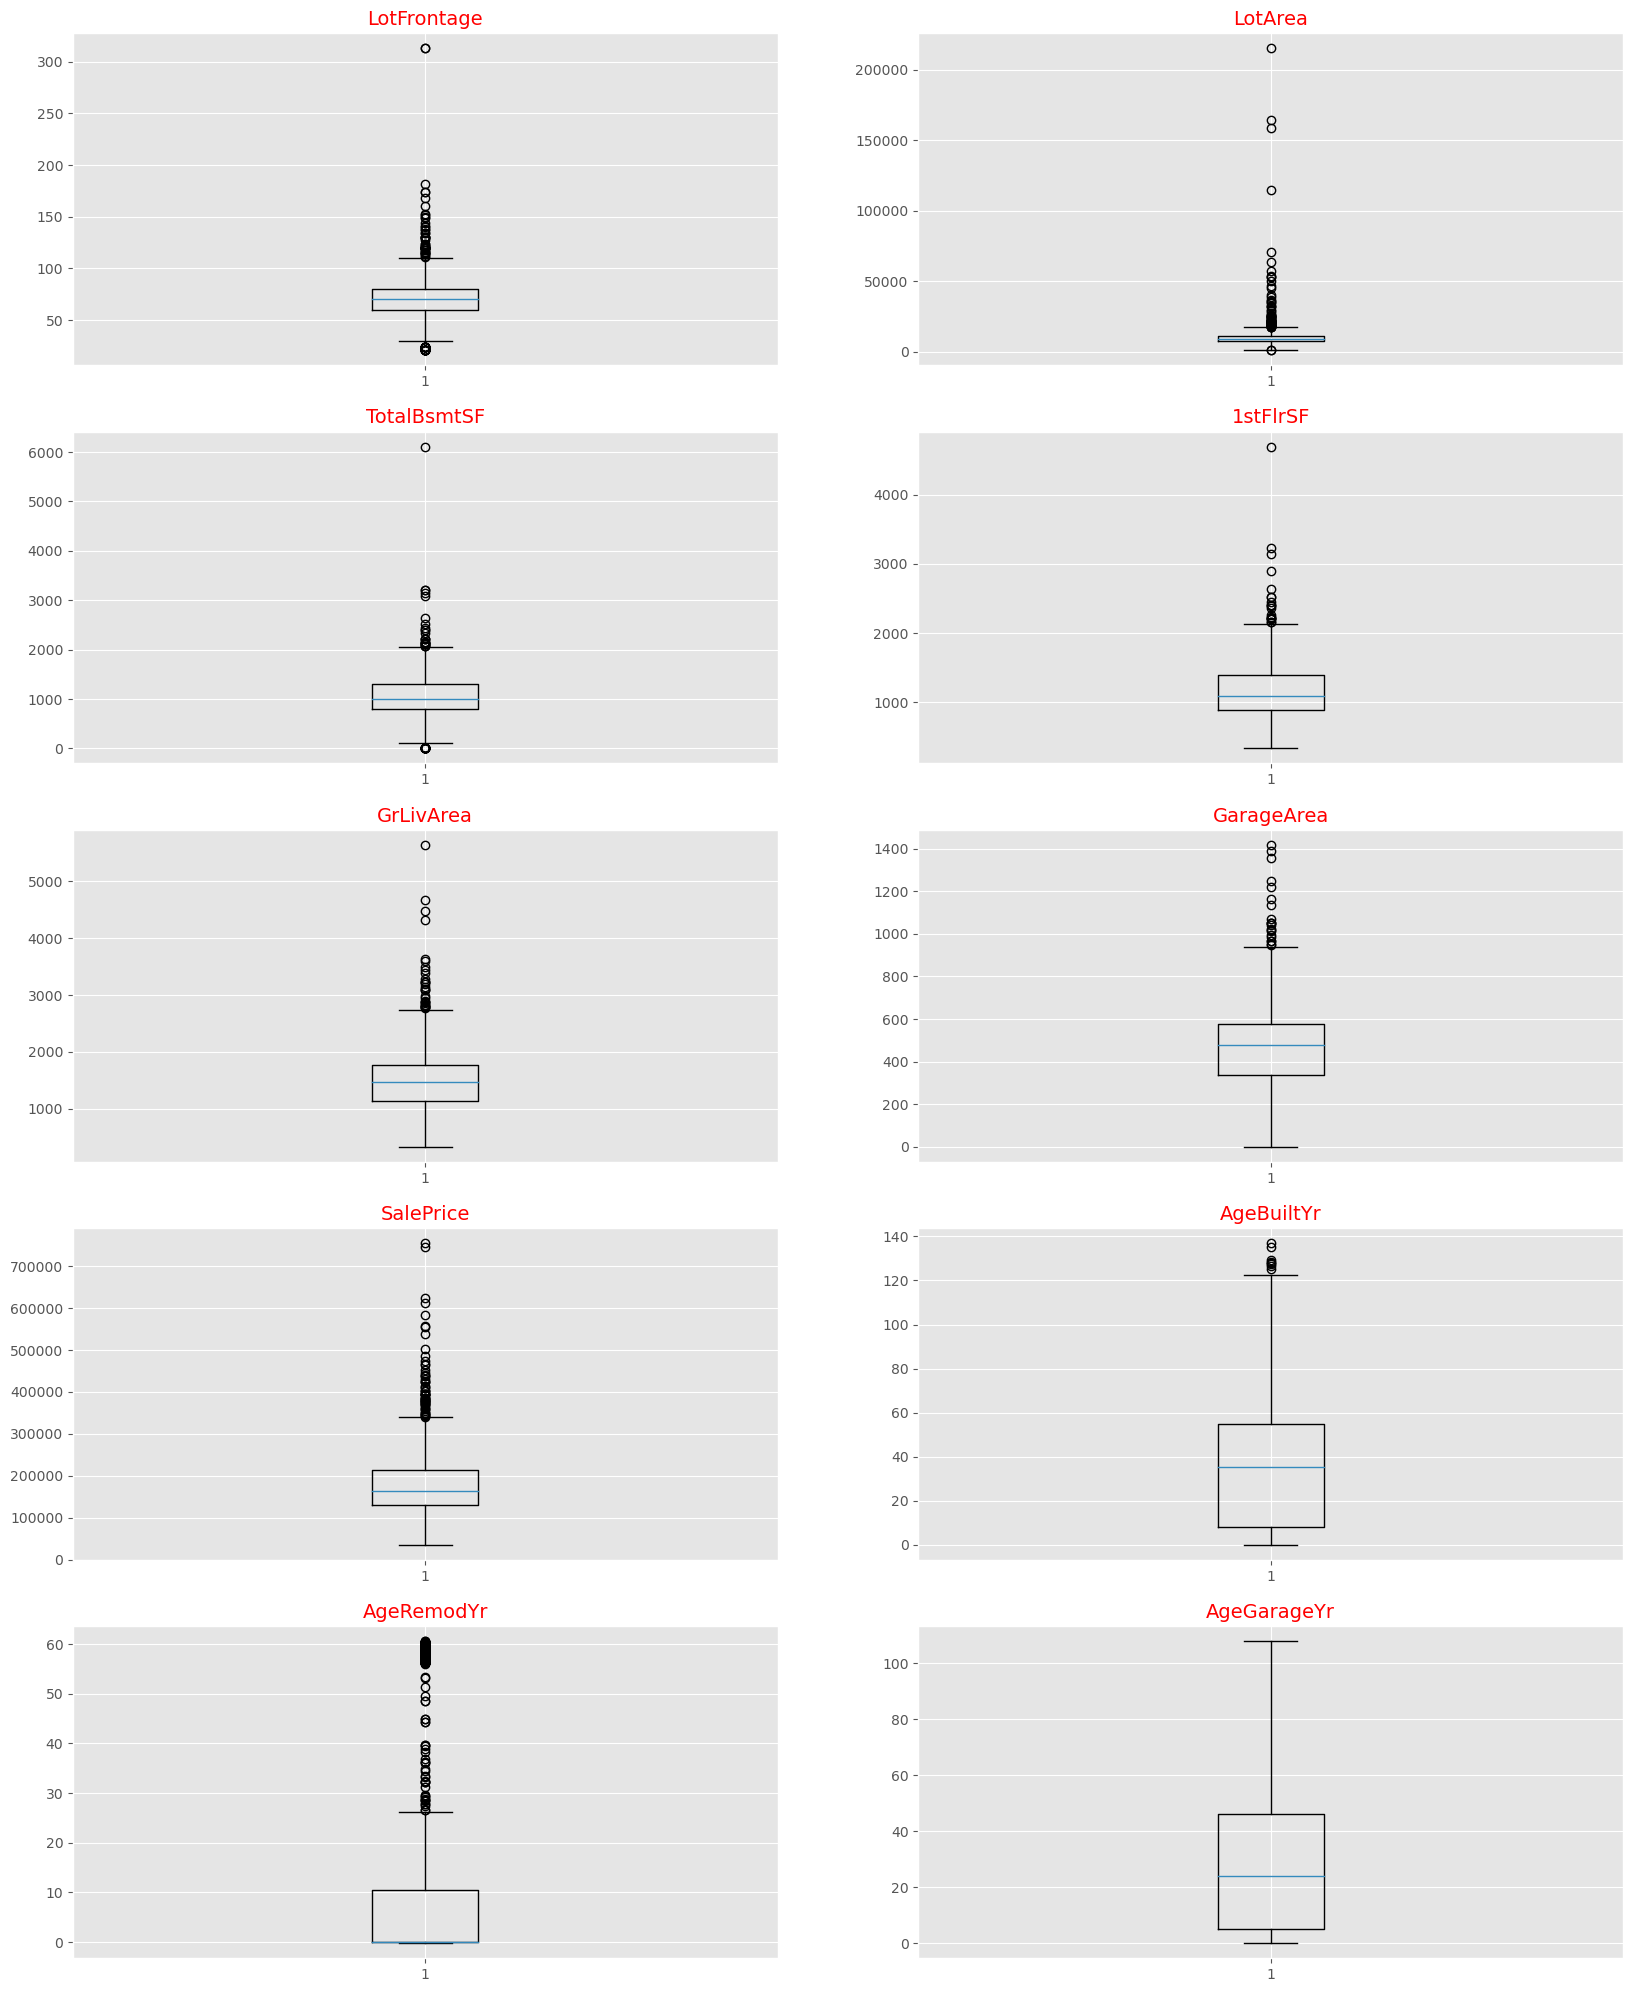

In [31]:
plt.figure(figsize=(20,25))
x_list = []
x_list.extend(['LotFrontage','LotArea','TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea','SalePrice','AgeBuiltYr',
               'AgeRemodYr','AgeGarageYr'])
p=1
for i in x_list:
    plt.subplot(5,2,p)
    plt.boxplot(inp1[str(i)])
    plt.title(str(i),fontdict={'fontsize':14,'fontweight':5,'color':'Red'})
    p += 1

plt.show()

**Obervation**<br>
There are clear indications of outliers for features LotFrontage, LotArea, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea and 
SalePrice while the remaining features have continous values among the outliers.<br>
However, we need to check if these are genuine outliers by checking the percentiles & the sale price of the property.Even 
though there are outliers in these features, the sales price may every be within the accepted range which is acceptables.
The assumption here is there are other factors which may be bringing the sales price within the accepted range which cannot
be explained by the outliers. <br>
Also, since the data set is quite small, it would be best not to delete any observations.

**Action**<br>
Find the key perctiles for the notes features above to confirm whether the values are continuous.<br>
Further find observations which satisfy the conditions to determine whether to drop the rows.

In [32]:
#create dataframe based on percentiles to further check for outliers
y_list=[]
z_list=[]
q_list=[0.5, 0.75,0.90, 0.95, 0.97,0.98, 0.99]
for i in x_list:
    z_list=[]
    z_list.append(str(i))
    for j in q_list:
        z_list.append(round(inp1[str(i)].quantile(j),2))
    y_list.append(z_list)

y_df = pd.DataFrame(y_list,columns=['Feature','0.5','0.75','0.90','0.95','0.97','0.98','0.99'])
y_df

,Feature,0.5,0.75,0.90,0.95,0.97,0.98,0.99
0,LotFrontage,70.00,80.00,92.00,104.00,114.00,120.82,137.41
1,LotArea,9478.50,11601.50,14381.70,17401.15,21571.80,25251.62,37567.64
2,TotalBsmtSF,991.50,1298.25,1602.20,1753.00,1905.46,2001.64,2155.05
3,1stFlrSF,1087.00,1391.25,1680.00,1831.25,1981.61,2072.28,2219.46
4,GrLivArea,1464.00,1776.75,2158.30,2466.10,2633.23,2782.38,3123.48
5,GarageArea,480.00,576.00,757.10,850.10,884.00,907.46,1002.79
6,SalePrice,163000.00,214000.00,278000.00,326100.00,374230.00,394931.06,442567.01
7,AgeBuiltYr,35.42,54.83,84.03,91.26,97.08,100.42,110.95
8,AgeRemodYr,0.00,10.52,56.42,58.25,59.33,59.58,60.25
9,AgeGarageYr,24.00,46.19,61.26,78.43,84.37,87.74,90.40


**Observations**<br>
All the features except *LotArea* have continous values among the percentiles with none standing out starkly. <Br>
Therefore let us get the number of rows where we see high number of outliers and check the sales price of these properties.

In [33]:
#find the sales price of property whose lot frontage are within the outliers
inp1[['LotFrontage','LotArea','TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea','SalePrice']][(inp1['LotFrontage']>200)]

,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
934,313,27650,585,2069,2069,505,242000
1298,313,63887,6110,4692,5642,1418,160000


**Observation**<br>
Note that the sales price of the property is within the accepted range, therefore it would not be ideal to remove these rows.
This could possibly mean that on more than one side of the property there is a street. Therefore a pattern must be 
found within this to explain why the sales price is not abnormal. 

In [34]:
#find the sales price of property whose lot areas are within the outliers
inp1[['SalePrice']][(inp1['LotArea']>17000)].describe()

,SalePrice
count,79.000000
mean,235212.620253
std,120204.737777
min,81000.000000
25%,160000.000000
50%,197900.000000
75%,268612.500000
max,755000.000000


**Observation**<br>
With higher lot area above 17,000 , the sales price ranges from low of 81,000 to a max of 755,000 implying that higher
lot sizes does not guarantee higher sales price. Therefore, there is a hidden pattern here and these rows cannot be 
dropped. However, the correlation of these features needs to still be checked.

In [35]:
#find the sales price of property with all parameters that are within the outliers
inp1[['SalePrice']][(inp1['LotFrontage']>130) & (inp1['LotArea']>22000) & (inp1['TotalBsmtSF']>2000) & (inp1['1stFlrSF']>2000 &
     (inp1['GrLivArea']>2600) & (inp1['GarageArea']>900)) ]

,SalePrice
313,375000
1298,160000


**Observation**<br>
Here too, we see that the sales price is still acceptable and since this is the dependent variable, it would be best not to
drop these rows.<br>

So far, there isn't strong evidence to drop rows that may satisfy the outliers found above because:<br>
1. number of observations provided are few <br>
2. hidden patterns are not found yet as the sales price of such outliers are within acceptable ranges.

In [36]:
#features after data cleaning & manipulation
inp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1460 non-null   object 
 1   MSZoning      1460 non-null   object 
 2   LotFrontage   1460 non-null   int64  
 3   LotArea       1460 non-null   int64  
 4   LotShape      1460 non-null   object 
 5   LotConfig     1460 non-null   object 
 6   Neighborhood  1460 non-null   object 
 7   HouseStyle    1460 non-null   object 
 8   OverallQual   1460 non-null   object 
 9   OverallCond   1460 non-null   object 
 10  RoofStyle     1460 non-null   object 
 11  Exterior1st   1460 non-null   object 
 12  Exterior2nd   1460 non-null   object 
 13  MasVnrType    1460 non-null   object 
 14  ExterQual     1460 non-null   object 
 15  Foundation    1460 non-null   object 
 16  BsmtQual      1460 non-null   object 
 17  BsmtExposure  1460 non-null   object 
 18  BsmtFinType1  1460 non-null 

**Result**<br>
All data cleaning and manipulation is now complete. <br>
There are no missing values in any of the features.

### III. Expolatory Data Analysis

**1. Correlation matrix in a heatmap**

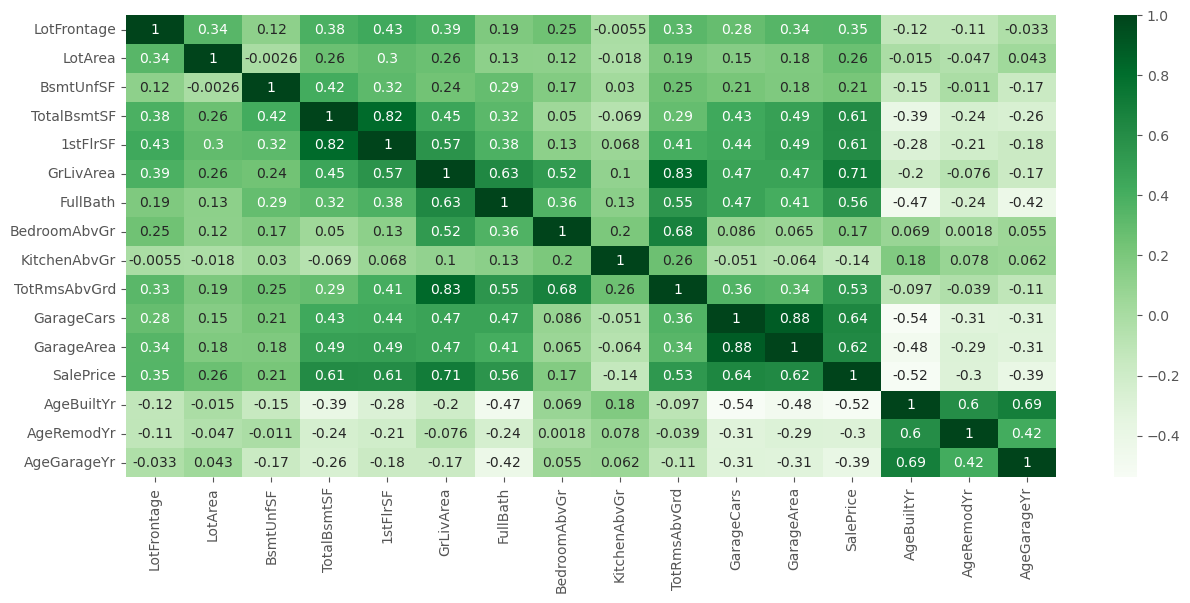

In [48]:
plt.figure(figsize=(15,6))
sns.heatmap(inp1.corr(), annot=True, cmap='Greens' )
plt.show()

In [37]:
#check for corelation with sales price;if none exist, then drop the columns
#TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF ; drop columns
#TotRmsAbvGrd = BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr
#GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF